In [1]:
# import Python packages, modules and functions

%matplotlib inline

import numpy as np
import pandas as pd
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
import matplotlib.pyplot as plt
from dataGeneratorClass import dataGenerator, plotData # this module is on my GitHub page
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import warnings
from importlib import reload
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth', -1)
def pretty_df(df, n = 10):
    return df.head(n).style.set_properties(**{'text-align': 'center',
                            'white-space': 'nowrap'})

In [2]:
# Generate data 

catg_lvls = [5, 8, 3] # 3 categorical variables with corresponding # of levels
n_cat = len(catg_lvls)
n_beta = 2 # number of beta variables
n_uniform = 1 # of uniform variables
n = n_cat + n_beta + n_uniform
N = 120000 # number of observations
responseMean = 0.05 # Bernoulli response mean
p_width = 0.1
np.random.seed(123)
trainPercent = 2./3 # fraction of data for training
testPercent = 1./6 # fraction of data for test
Ntrain = int(N * trainPercent);
Ntest = int(N * testPercent)

# Generate data
x = dataGenerator(catg_lvls = catg_lvls, n_beta = n_beta, n_uniform = n_uniform)
df1, df2 = x.generate(1000)
f = x.genSigmoidTransform(df2, loc = responseMean, width = p_width)
df1, df2 = x.generate_more(N)
df = pd.concat([df1,pd.DataFrame(x.genBernoulliVariates(df2,f),columns=['Response'])],axis=1)

In [3]:
# Split data into train, test and validate
train, test, validate = np.split(df.sample(frac=1,random_state = 0),indices_or_sections=[Ntrain,Ntrain + Ntest])
train = train.reset_index()
test = test.reset_index()
validate = validate.reset_index()

In [4]:
# Take a look at the training data
pretty_df(train)

,index,Feature: 0,Feature: 1,Feature: 2,Feature: 3,Feature: 4,Feature: 5,Response
0,40739,3,4,1,0.194392,0.205206,0.682438,0
1,105532,1,5,1,0.0886995,0.579297,0.979833,1
2,45004,2,4,2,0.222101,0.0586179,0.859653,0
3,71894,3,5,0,0.277352,0.474923,0.0230137,0
4,11970,4,7,1,0.108871,0.325363,0.353809,0
5,9382,1,4,1,0.405997,0.327751,0.10401,0
6,30582,2,2,1,0.291029,0.285454,0.520948,0
7,110897,2,4,0,0.164112,0.273223,0.0710168,0
8,64112,1,3,1,0.474486,0.0190688,0.498027,0
9,77897,3,6,0,0.102382,0.793129,0.428013,0


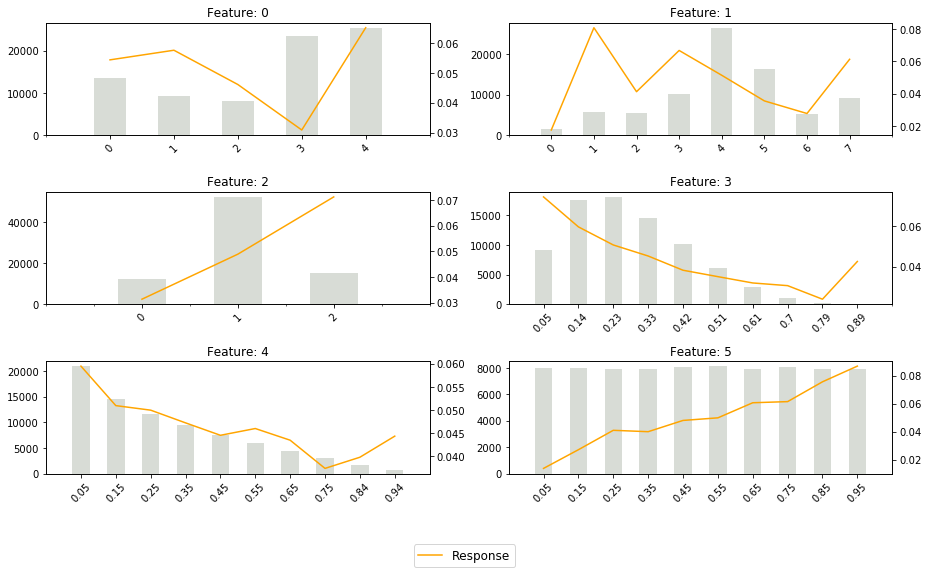

In [5]:
# Plot the training data
plotData(train.loc[:,train.columns != 'index'], response = 'Response')

In [6]:
# Initialize h2o instance
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.121-b13, mixed mode)
  Starting server from C:\Users\Gregory\Anaconda2\envs\python35\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Gregory\AppData\Local\Temp\tmp0pf5sg02
  JVM stdout: C:\Users\Gregory\AppData\Local\Temp\tmp0pf5sg02\h2o_Gregory_started_from_python.out
  JVM stderr: C:\Users\Gregory\AppData\Local\Temp\tmp0pf5sg02\h2o_Gregory_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,4 months and 29 days !!!
H2O cluster name:,H2O_from_python_Gregory_a4tegq
H2O cluster total nodes:,1
H2O cluster free memory:,1.761 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [7]:
# Construct dictionary of categorical variables
cat_dict = {k: 'categorical' for k, v in train.dtypes.to_dict().items() if v.name == 'category'}
cat_dict['Response'] = 'categorical'

In [8]:
# Read pandas dataframes into h2o
train_h2o = h2o.H2OFrame(train,column_types=cat_dict)
test_h2o = h2o.H2OFrame(test,column_types=cat_dict)
validate_h2o = h2o.H2OFrame(validate,column_types=cat_dict)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
# Print h2o training data
train_h2o

index,Feature: 0,Feature: 1,Feature: 2,Feature: 3,Feature: 4,Feature: 5,Response
40739,3,4,1,0.194392,0.205206,0.682438,0
105532,1,5,1,0.0886995,0.579297,0.979833,1
45004,2,4,2,0.222101,0.0586179,0.859653,0
71894,3,5,0,0.277352,0.474923,0.0230137,0
11970,4,7,1,0.108871,0.325363,0.353809,0
9382,1,4,1,0.405997,0.327751,0.10401,0
30582,2,2,1,0.291029,0.285454,0.520948,0
110897,2,4,0,0.164112,0.273223,0.0710168,0
64112,1,3,1,0.474486,0.0190688,0.498027,0
77897,3,6,0,0.102382,0.793129,0.428013,0


In [10]:
# Check that categorical variables are indeed factors in h2o
train_h2o.isfactor()

[False, True, True, True, False, False, False, True]

In [11]:
# Column names in h2o
train_h2o.col_names

['index',
 'Feature: 0',
 'Feature: 1',
 'Feature: 2',
 'Feature: 3',
 'Feature: 4',
 'Feature: 5',
 'Response']

In [12]:
# Set up gbm parameter grid and fit in h2o
hyper_parameters = {'ntrees': [50,100,150,200],
                    'max_depth': [2,4,8],
                    'learn_rate': [0.01, 0.05, 0.1, 0.2]}

gbm_grid = H2OGridSearch(H2OGradientBoostingEstimator(distribution='bernoulli'), hyper_parameters)
gbm_grid.train(training_frame = train_h2o,
        x = [i for i in train_h2o.col_names if i not in ['Response','index']],
        y = 'Response',
        validation_frame = test_h2o)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [13]:
# Get best gbm and print summary
gbm_grid_perf = gbm_grid.get_grid(sort_by='logloss',decreasing=False)
best_gbm = gbm_grid_perf.models[0]
print(best_gbm)
print('Gini for the best GBM:')
print(round(best_gbm.model_performance(test_h2o).gini(),3))

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_model_python_1540313160367_1_model_39


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.04689835176684326
RMSE: 0.21656027282685822
LogLoss: 0.18902292700837434
Mean Per-Class Error: 0.36610109772231736
AUC: 0.6846472014642496
Gini: 0.36929440292849924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07315069669112084: 


,0,1,Error,Rate
0,59142.0,16823.0,0.2215,(16823.0/75965.0)
1,2258.0,1777.0,0.5596,(2258.0/4035.0)
Total,61400.0,18600.0,0.2385,(19081.0/80000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0731507,0.1570135,153.0
max f2,0.0533543,0.2732767,220.0
max f0point5,0.1044167,0.1254720,68.0
max accuracy,0.1819214,0.9496375,7.0
max precision,0.3361636,1.0,0.0
max recall,0.0049016,1.0,394.0
max specificity,0.3361636,1.0,0.0
max absolute_mcc,0.0533543,0.1184876,220.0
max min_per_class_accuracy,0.0569842,0.6294919,207.0
max mean_per_class_accuracy,0.0512302,0.6338989,228.0


Gains/Lift Table: Avg response rate:  5.04 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.1182738,3.0235440,3.0235440,0.1525,0.1525,0.0302354,0.0302354,202.3543990,202.3543990
,2,0.02,0.1117674,2.4287485,2.7261462,0.1225,0.1375,0.0242875,0.0545229,142.8748451,172.6146221
,3,0.0301125,0.1081197,2.4262364,2.6254293,0.1223733,0.1324201,0.0245353,0.0790582,142.6236439,162.5429320
,4,0.04,0.1044959,2.5065130,2.5960347,0.1264223,0.1309375,0.0247831,0.1038414,150.6513017,159.6034696
,5,0.0500125,0.1020652,1.7574067,2.4281414,0.0886392,0.1224694,0.0175960,0.1214374,75.7406711,142.8141416
,6,0.1001875,0.0925938,1.9164646,2.1718881,0.0966617,0.1095446,0.0961586,0.2175960,91.6464617,117.1888057
,7,0.15,0.0841210,1.8010538,2.0487402,0.0908407,0.1033333,0.0897150,0.3073110,80.1053828,104.8740190
,8,0.2000625,0.0772541,1.5940421,1.9349591,0.0803995,0.0975945,0.0798017,0.3871128,59.4042144,93.4959142
,9,0.3,0.0648821,1.4482410,1.7728211,0.0730457,0.0894167,0.1447336,0.5318463,44.8240962,77.2821148
,10,0.4,0.0550458,1.1747212,1.6232962,0.05925,0.081875,0.1174721,0.6493185,17.4721190,62.3296159




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.04608533153085346
RMSE: 0.2146749438822646
LogLoss: 0.1875194083880317
Mean Per-Class Error: 0.3691442123192793
AUC: 0.6669806406073105
Gini: 0.3339612812146211
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07500535510845036: 


,0,1,Error,Rate
0,15032.0,3984.0,0.2095,(3984.0/19016.0)
1,610.0,374.0,0.6199,(610.0/984.0)
Total,15642.0,4358.0,0.2297,(4594.0/20000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0750054,0.1400225,140.0
max f2,0.0505459,0.2652070,224.0
max f0point5,0.0893495,0.1025446,99.0
max accuracy,0.1891060,0.9508,1.0
max precision,0.1891060,0.5,1.0
max recall,0.0090998,1.0,381.0
max specificity,0.2070402,0.9999474,0.0
max absolute_mcc,0.0430981,0.1135328,252.0
max min_per_class_accuracy,0.0556822,0.6189024,204.0
max mean_per_class_accuracy,0.0430981,0.6308558,252.0


Gains/Lift Table: Avg response rate:  4.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01015,0.1190487,2.4029797,2.4029797,0.1182266,0.1182266,0.0243902,0.0243902,140.2979695,140.2979695
,2,0.02,0.1119841,1.3412571,1.8800813,0.0659898,0.0925,0.0132114,0.0376016,34.1257067,88.0081301
,3,0.03,0.1079808,1.8292683,1.8631436,0.09,0.0916667,0.0182927,0.0558943,82.9268293,86.3143631
,4,0.04005,0.1047077,2.0224083,1.9031089,0.0995025,0.0936330,0.0203252,0.0762195,102.2408284,90.3108919
,5,0.05035,0.1020530,2.0719867,1.9376559,0.1019417,0.0953327,0.0213415,0.0975610,107.1986739,93.7655921
,6,0.1,0.0924362,1.8012265,1.8699187,0.0886203,0.092,0.0894309,0.1869919,80.1226471,86.9918699
,7,0.1501,0.0843589,1.5213475,1.7535735,0.0748503,0.0862758,0.0762195,0.2632114,52.1347549,75.3573498
,8,0.2002,0.0775643,1.5619168,1.7056115,0.0768463,0.0839161,0.0782520,0.3414634,56.1916817,70.5611462
,9,0.3,0.0648107,1.4459814,1.6192412,0.0711423,0.0796667,0.1443089,0.4857724,44.5981394,61.9241192
,10,0.4001,0.0545792,1.4721051,1.5824296,0.0724276,0.0778555,0.1473577,0.6331301,47.2105131,58.2429596



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-10-23 10:50:16,3 min 36.806 sec,0.0,0.2188460,0.1998014,0.5,1.0,0.9495625,0.2162889,0.1961690,0.5,1.0,0.9508
,2018-10-23 10:50:16,3 min 36.869 sec,1.0,0.2184749,0.1981225,0.6178713,1.5842365,0.2934625,0.2159456,0.1946342,0.6126421,1.5759524,0.29275
,2018-10-23 10:50:16,3 min 36.917 sec,2.0,0.2182066,0.1969046,0.6359545,1.6553152,0.2609625,0.2156973,0.1935061,0.6292935,1.6277935,0.2605
,2018-10-23 10:50:16,3 min 36.967 sec,3.0,0.2180090,0.1960489,0.6480502,1.8940652,0.2525875,0.2154919,0.1926143,0.6436581,1.8563001,0.2748
,2018-10-23 10:50:16,3 min 37.016 sec,4.0,0.2178547,0.1953039,0.6494291,2.0119934,0.204425,0.2153631,0.1920075,0.6428241,2.1546751,0.2748
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-10-23 10:50:20,3 min 40.653 sec,56.0,0.2167099,0.1895940,0.6804619,2.8004957,0.2548125,0.2147230,0.1878140,0.6653353,2.4390244,0.2225
,2018-10-23 10:50:20,3 min 40.724 sec,57.0,0.2167046,0.1895789,0.6805854,2.8147236,0.2502125,0.2147183,0.1878013,0.6654658,2.4390244,0.21825
,2018-10-23 10:50:20,3 min 40.793 sec,58.0,0.2166991,0.1895577,0.6809102,2.8960082,0.2583375,0.2147141,0.1877789,0.6657842,2.4390244,0.2192
,2018-10-23 10:50:24,3 min 44.804 sec,196.0,0.2165603,0.1890229,0.6846472,3.0235440,0.2385125,0.2146749,0.1875194,0.6669806,2.4029797,0.2297



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Feature: 5,91.7378922,1.0,0.4221333
Feature: 1,44.8925705,0.4893569,0.2065738
Feature: 3,29.9137249,0.3260782,0.1376484
Feature: 0,19.6679497,0.2143929,0.0905024
Feature: 2,17.3748608,0.1893968,0.0799507
Feature: 4,13.7327394,0.1496954,0.0631914



Gini for the best GBM:
0.334


In [14]:
# Use best gbm to score validation set
gbm_validation_preds = best_gbm.predict(validate_h2o).cbind(validate_h2o)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [15]:
# Convert scored validation set to pandas dataframe
gbm_validation_preds_df = gbm_validation_preds.as_data_frame(use_pandas=True)

In [16]:
# Set up random forest parameter grid and fit in h2o
hyper_parameters = {'ntrees': [50,100,150,200],
                    'max_depth': [8,16]}

rf_grid = H2OGridSearch(H2ORandomForestEstimator(distribution='bernoulli'), hyper_parameters)
rf_grid.train(training_frame = train_h2o,
        x = [i for i in train_h2o.col_names if i not in ['Response','index']],
        y = 'Response',
        validation_frame = test_h2o)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [17]:
# Take a look at grid results
rf_grid

    max_depth ntrees  \
0           8    200   
1           8    150   
2           8    100   
3           8     50   
4          16    200   
5          16    150   
6          16    100   
7          16     50   

                                                               model_ids  \
0  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   
1  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   
2  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   
3  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   
4  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   
5  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   
6  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   
7  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_mo...   

               logloss  
0   0.1878359834031628  
1  0.18794469859485508  
2  0.18800940435889638 

In [18]:
# Get best random forest from grid and print summary
rf_grid_perf = rf_grid.get_grid(sort_by='logloss',decreasing=False)
best_rf = rf_grid_perf.models[0]
print(best_rf)
print('Gini for the best Random Forest:')
print(round(best_rf.model_performance(test_h2o).gini(),3))

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  Grid_DRF_Key_Frame__upload_ad17888f3d11852a705f4cfd57254752.hex_model_python_1540313160367_5014_model_6


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.04716713134781206
RMSE: 0.21717995153285227
LogLoss: 0.19120053033534848
Mean Per-Class Error: 0.37801602854507044
AUC: 0.6643137700129462
Gini: 0.32862754002589245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07284339718175113: 


,0,1,Error,Rate
0,59396.0,16569.0,0.2181,(16569.0/75965.0)
1,2424.0,1611.0,0.6007,(2424.0/4035.0)
Total,61820.0,18180.0,0.2374,(18993.0/80000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0728434,0.1450371,153.0
max f2,0.0514282,0.2632582,228.0
max f0point5,0.0805273,0.1073943,130.0
max accuracy,0.4278396,0.94955,0.0
max precision,0.2819228,0.3333333,2.0
max recall,0.0021825,1.0,399.0
max specificity,0.4278396,0.9999868,0.0
max absolute_mcc,0.0493410,0.1068476,236.0
max min_per_class_accuracy,0.0562230,0.6161090,209.0
max mean_per_class_accuracy,0.0493410,0.6219840,236.0


Gains/Lift Table: Avg response rate:  5.04 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.1132102,1.8091698,1.8091698,0.09125,0.09125,0.0180917,0.0180917,80.9169765,80.9169765
,2,0.02,0.1063857,1.6356877,1.7224287,0.0825,0.086875,0.0163569,0.0344486,63.5687732,72.2428748
,3,0.03,0.1025407,2.0322181,1.8256919,0.1025,0.0920833,0.0203222,0.0547708,103.2218092,82.5691863
,4,0.04,0.0996819,2.3048327,1.9454771,0.11625,0.098125,0.0230483,0.0778191,130.4832714,94.5477076
,5,0.05,0.0971961,2.1065675,1.9776952,0.10625,0.09975,0.0210657,0.0988848,110.6567534,97.7695167
,6,0.1,0.0893451,1.8339529,1.9058240,0.0925,0.096125,0.0916976,0.1905824,83.3952912,90.5824040
,7,0.15,0.0829297,1.6505576,1.8207352,0.08325,0.0918333,0.0825279,0.2731103,65.0557621,82.0735233
,8,0.2,0.0764201,1.7100372,1.7930607,0.08625,0.0904375,0.0855019,0.3586121,71.0037175,79.3060719
,9,0.3,0.0642209,1.3952912,1.6604709,0.070375,0.08375,0.1395291,0.4981413,39.5291202,66.0470880
,10,0.4,0.0555390,1.2490706,1.5576208,0.063,0.0785625,0.1249071,0.6230483,24.9070632,55.7620818




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.04611823508288964
RMSE: 0.2147515659614375
LogLoss: 0.1878359834031628
Mean Per-Class Error: 0.3693374599395973
AUC: 0.6630260118992649
Gini: 0.3260520237985298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.060304261710037256: 


,0,1,Error,Rate
0,12759.0,6257.0,0.329,(6257.0/19016.0)
1,453.0,531.0,0.4604,(453.0/984.0)
Total,13212.0,6788.0,0.3355,(6710.0/20000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0603043,0.1366444,187.0
max f2,0.0460653,0.2633572,242.0
max f0point5,0.0951407,0.1011944,75.0
max accuracy,0.2588851,0.95075,0.0
max precision,0.1354579,0.2,17.0
max recall,0.0056871,1.0,390.0
max specificity,0.2588851,0.9999474,0.0
max absolute_mcc,0.0444193,0.1134901,249.0
max min_per_class_accuracy,0.0556037,0.6097561,204.0
max mean_per_class_accuracy,0.0453668,0.6306625,245.0


Gains/Lift Table: Avg response rate:  4.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.1128753,2.0325203,2.0325203,0.1,0.1,0.0203252,0.0203252,103.2520325,103.2520325
,2,0.02,0.1058437,1.7276423,1.8800813,0.085,0.0925,0.0172764,0.0376016,72.7642276,88.0081301
,3,0.03,0.1025203,1.8292683,1.8631436,0.09,0.0916667,0.0182927,0.0558943,82.9268293,86.3143631
,4,0.04,0.0999027,2.3373984,1.9817073,0.115,0.0975,0.0233740,0.0792683,133.7398374,98.1707317
,5,0.05,0.0974017,2.1341463,2.0121951,0.105,0.099,0.0213415,0.1006098,113.4146341,101.2195122
,6,0.1,0.0897549,1.6056911,1.8089431,0.079,0.089,0.0802846,0.1808943,60.5691057,80.8943089
,7,0.15,0.0831048,1.4634146,1.6937669,0.072,0.0833333,0.0731707,0.2540650,46.3414634,69.3766938
,8,0.2,0.0766030,1.6869919,1.6920732,0.083,0.08325,0.0843496,0.3384146,68.6991870,69.2073171
,9,0.3,0.0638058,1.3922764,1.5921409,0.0685,0.0783333,0.1392276,0.4776423,39.2276423,59.2140921
,10,0.4,0.0553296,1.3313008,1.5269309,0.0655,0.075125,0.1331301,0.6107724,33.1300813,52.6930894



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-10-23 10:53:44,54.583 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2018-10-23 10:53:44,54.636 sec,1.0,0.2171398,0.2471994,0.6315580,1.8930864,0.2236212,0.2162037,0.2179374,0.6392927,1.7276423,0.29845
,2018-10-23 10:53:44,54.699 sec,2.0,0.2186866,0.2299020,0.6381208,1.6741330,0.2520257,0.2155975,0.1924018,0.6446634,1.8147503,0.35165
,2018-10-23 10:53:44,54.798 sec,3.0,0.2180256,0.2179137,0.6395119,1.3878563,0.2684883,0.2151312,0.1893820,0.6541947,2.0776874,0.37175
,2018-10-23 10:53:44,54.888 sec,4.0,0.2183148,0.2151906,0.6403813,1.4507208,0.2134370,0.2149963,0.1886794,0.6591229,1.9308943,0.2636
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-10-23 10:53:47,58.026 sec,23.0,0.2175309,0.1922148,0.6574430,1.4374226,0.2481499,0.2148436,0.1880089,0.6624609,1.5243902,0.30335
,2018-10-23 10:53:47,58.270 sec,24.0,0.2175065,0.1921269,0.6580141,1.5365551,0.2486593,0.2148323,0.1879920,0.6623303,1.7276423,0.3235
,2018-10-23 10:53:47,58.493 sec,25.0,0.2175084,0.1921542,0.6576152,1.5613383,0.2485687,0.2148373,0.1880371,0.6616916,1.6260163,0.31985
,2018-10-23 10:53:51,1 min 2.494 sec,169.0,0.2171873,0.1912220,0.6642582,1.8339529,0.248775,0.2147596,0.1878753,0.6625311,1.8292683,0.2837



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Feature: 5,5853.8183594,1.0,0.3285605
Feature: 3,3661.4194336,0.6254754,0.2055065
Feature: 4,2641.6740723,0.4512737,0.1482707
Feature: 1,2422.6738281,0.4138621,0.1359788
Feature: 0,2077.7668457,0.3549421,0.1166200
Feature: 2,1159.2093506,0.1980262,0.0650636



Gini for the best Random Forest:
0.326


In [19]:
# Use best random forest to score validation set
rf_validation_preds = best_rf.predict(validate_h2o).cbind(validate_h2o)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [20]:
# Convert scored validation set to pandas dataframe
rf_validation_preds_df = rf_validation_preds.as_data_frame(use_pandas=True)

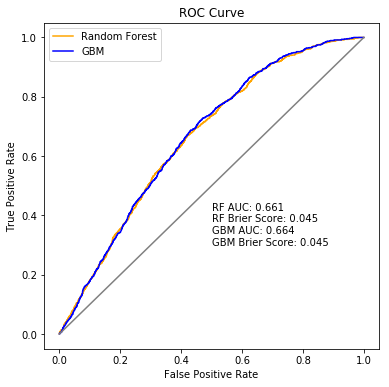

In [21]:
# Construct ROC curves, calculate AUC and Brier Score and plot
fpr_rf, tpr_rf, thresholds_rf = roc_curve(rf_validation_preds_df.Response, rf_validation_preds_df.p1)
AUC_rf = roc_auc_score(rf_validation_preds_df.Response, rf_validation_preds_df.p1)
BrierScore_rf = brier_score_loss(rf_validation_preds_df.Response, rf_validation_preds_df.p1)

fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(gbm_validation_preds_df.Response, gbm_validation_preds_df.p1)
AUC_gbm = roc_auc_score(gbm_validation_preds_df.Response, gbm_validation_preds_df.p1)
BrierScore_gbm = brier_score_loss(gbm_validation_preds_df.Response, gbm_validation_preds_df.p1)

fig, axes = plt.subplots(1,1,figsize=(6,6))
axes.plot(fpr_rf,tpr_rf, color = 'orange', label = 'Random Forest')
axes.plot(fpr_gbm,tpr_gbm, color = 'blue', label = 'GBM')
axes.plot(np.array([0,1]),np.array([0,1]), color = 'grey')
axes.text(.5,.3,('RF AUC: {0}' + 
                 '\nRF Brier Score: {1}' +
                 '\nGBM AUC: {2}' + 
                 '\nGBM Brier Score: {3}').
          format(round(AUC_rf,3),
                 round(BrierScore_rf,3),
                 round(AUC_gbm,3),
                 round(BrierScore_gbm,3)))
axes.set_title('ROC Curve'); axes.set_xlabel('False Positive Rate'); axes.set_ylabel('True Positive Rate'); axes.legend()

In [22]:
# Shutdown h2o
h2o.cluster().shutdown()

H2O session _sid_84df closed.
